<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Bispectrum-counter-example" data-toc-modified-id="Bispectrum-counter-example-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Bispectrum counter example</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#optimize-structures" data-toc-modified-id="optimize-structures-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>optimize structures</a></span></li></ul></li><li><span><a href="#Feature-computation" data-toc-modified-id="Feature-computation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Feature computation</a></span><ul class="toc-item"><li><span><a href="#$\rho_{i}^{\otimes-3}$" data-toc-modified-id="$\rho_{i}^{\otimes-3}$-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>$\rho_{i}^{\otimes 3}$</a></span></li><li><span><a href="#check-map-between-three-center-and-single-center" data-toc-modified-id="check-map-between-three-center-and-single-center-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>check map between three center and single center</a></span></li><li><span><a href="#check-degeneracy-of-$\rho_{i}^{\otimes-3}$" data-toc-modified-id="check-degeneracy-of-$\rho_{i}^{\otimes-3}$-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>check degeneracy of $\rho_{i}^{\otimes 3}$</a></span></li><li><span><a href="#artificial-structure" data-toc-modified-id="artificial-structure-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>artificial structure</a></span></li></ul></li><li><span><a href="#encoder-decoder" data-toc-modified-id="encoder-decoder-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>encoder-decoder</a></span><ul class="toc-item"><li><span><a href="#train-different-blocks-separately" data-toc-modified-id="train-different-blocks-separately-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>train different blocks separately</a></span></li><li><span><a href="#tensormap-of-reconstructed-features" data-toc-modified-id="tensormap-of-reconstructed-features-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>tensormap of reconstructed features</a></span></li></ul></li><li><span><a href="#set-up-NICE-style-feature-computation" data-toc-modified-id="set-up-NICE-style-feature-computation-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>set up NICE style feature computation</a></span></li><li><span><a href="#encoder-decoder-like-architecture---nope" data-toc-modified-id="encoder-decoder-like-architecture---nope-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>encoder-decoder like architecture - nope</a></span><ul class="toc-item"><li><span><a href="#$\rho_{i}^{\otimes-3}$" data-toc-modified-id="$\rho_{i}^{\otimes-3}$-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>$\rho_{i}^{\otimes 3}$</a></span></li><li><span><a href="#$\rho_{i-i_1-i_2}^{\otimes-1}$" data-toc-modified-id="$\rho_{i-i_1-i_2}^{\otimes-1}$-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>$\rho_{i i_1 i_2}^{\otimes 1}$</a></span></li><li><span><a href="#check-degeneracy-of-$\rho_{i}^{\otimes-3}$" data-toc-modified-id="check-degeneracy-of-$\rho_{i}^{\otimes-3}$-1.4.3"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>check degeneracy of $\rho_{i}^{\otimes 3}$</a></span></li></ul></li></ul></li></ul></div>

# Bispectrum counter example

In [1]:
%load_ext autoreload
%autoreload 2 

In [7]:
from ase.io import read,write
from ase.visualize import view
import numpy as np 

from equistore import Labels, TensorBlock, TensorMap
from itertools import product
from utils.clebsh_gordan import ClebschGordanReal

import matplotlib.pyplot as plt

from utils.librascal import  RascalSphericalExpansion, RascalPairExpansion
from rascal.representations import SphericalExpansion
import copy
import ase 
import tqdm 

In [8]:
from utils.mp_utils import *

In [9]:
from generate_bispectrum_structures import generate_nu3_degen_structs, analytical_partial_derivative

In [4]:
import pyscf
from pyscf import gto
from pyscf import scf,dft

#gto.M default unit being Angstrom
def pyscf_rks_calc(frame):
    pts = frame.get_positions()
    els = frame.get_chemical_symbols()
    natoms = len(pts)
    atoms = []
    for i in range(natoms):
        coord = pts[i]
        atoms.append([els[i],(coord[0],coord[1],coord[2])])
    mol = gto.M(atom=atoms,symmetry = True)
    mol.basis = "ccpvdz" #"def2-SVP" 
#     mol.basis = {'O': 'ccpvdz', 'H': 'ccpvdz', 'C': 'ccpvdz', 'N':'ccpvdz', 'Ag': 'def2-svp'} 
    mol.charge=0
    mol.spin = 0
    mol.build()
    m = scf.RKS(mol)
#     m = scf.RHF(mol)
    m.xc="pbe"
    m.max_cycle=600
    m.conv_tol=1e-9
    m.conv_tol_grad=1e-8
    m.diis_space=10
#     print(mol.ao_labels())

    return m.kernel() 

def pyscf_rhf_calc(frame):
    pts = frame.get_positions()
    els = frame.get_chemical_symbols()
    natoms = len(pts)
    atoms = []
    for i in range(natoms):
        coord = pts[i]
        atoms.append([els[i],(coord[0],coord[1],coord[2])])
    mol = gto.M(atom=atoms,symmetry = True)
    mol.basis = "ccpvdz" #"def2-SVP" 
#     mol.basis = {'O': 'ccpvdz', 'H': 'ccpvdz', 'C': 'ccpvdz', 'N':'ccpvdz', 'Ag': 'def2-svp'} 
    mol.charge=0
    mol.spin = 0
    mol.build()
#     m = scf.RKS(mol)
    m = scf.RHF(mol)
#     m.xc="pbe"
    m.max_cycle=500
    m.conv_tol=1e-9
#     m.conv_tol_grad=1e-8
    m.diis_space=10
#     print(mol.ao_labels())

    return m.kernel() 

from pyscf.pbc.tools.pyscf_ase import atoms_from_ase
def dftblock(frames, start, end, basis='ccpvdz', xc='pbe'):
#     frames = read(prefix+".xyz", "%d:%d" % (start,end))
    idx_nconv=[]
    for i, f in enumerate(tqdm.tqdm(frames[start:end])):
        if "label" in f.info:
            label = f.info["label"]
        else:
            label = str(start+i)    
        f.info = {}
        mol = pyscf.gto.M(atom = atoms_from_ase(f), basis = basis)
        rks = pyscf.dft.RKS(mol)
        rks = pyscf.scf.addons.smearing_(rks, sigma=.01, method='fermi')
        rks.xc = xc  
        rks.grids.level = 5 
        rks.verbose = 3 
        rks.init_guess = 'minao'
        rks.scf(print=True) 
        try:
            assert rks.converged==True
            print("converged")
        except: 
            print(i)
            idx_nconv.append(start+i)
        dft = rks.e_free # energy_tot()
        ddft = rks.nuc_grad_method().grad()
        f.info["energy_ha"] = dft 
        f.arrays["gradient_habohr"] = ddft
        f.info["label"] = label
        f.info["basis"] = basis
        f.info["xc"] = xc
    return frames, idx_nconv

pyscf plugins found in 
/Users/jigyasa/scratch/pyscf
/Users/jigyasa/scratch/./pyscf
/Users/jigyasa/miniconda3/lib/python3.8/site-packages/pyscf
When PYTHONPATH is set, it is recommended to load these plugins through the environment variable PYSCF_EXT_PATH


In [11]:
import pyscf
from pyscf import gto
from pyscf import scf,dft

def pyscf_rks_calc(frame):
    pts = frame.get_positions()
    els = frame.get_chemical_symbols()
    natoms = len(pts)
    atoms = []
    for i in range(natoms):
        coord = pts[i]
        atoms.append([els[i],(coord[0],coord[1],coord[2])])
    mol = gto.M(atom=atoms,symmetry = True)
    mol.basis = "ccpvdz" #"def2-SVP" 
#     mol.basis = {'O': 'ccpvdz', 'H': 'ccpvdz', 'C': 'ccpvdz', 'N':'ccpvdz', 'Ag': 'def2-svp'} 
    mol.charge=0
    mol.spin = 0
    mol.build()
    m = scf.RKS(mol)
#     m = scf.RHF(mol)
    m.xc="pbe"
    m.max_cycle=600
    m.conv_tol=1e-9
    m.conv_tol_grad=1e-8
    m.diis_space=10
#     print(mol.ao_labels())

    return m.kernel() 

def pyscf_rhf_calc(frame):
    pts = frame.get_positions()
    els = frame.get_chemical_symbols()
    natoms = len(pts)
    atoms = []
    for i in range(natoms):
        coord = pts[i]
        atoms.append([els[i],(coord[0],coord[1],coord[2])])
    mol = gto.M(atom=atoms,symmetry = True)
    mol.basis = "ccpvdz" #"def2-SVP" 
#     mol.basis = {'O': 'ccpvdz', 'H': 'ccpvdz', 'C': 'ccpvdz', 'N':'ccpvdz', 'Ag': 'def2-svp'} 
    mol.charge=0
    mol.spin = 0
    mol.build()
#     m = scf.RKS(mol)
    m = scf.RHF(mol)
#     m.xc="pbe"
    m.max_cycle=500
    m.conv_tol=1e-9
#     m.conv_tol_grad=1e-8
    m.diis_space=10
#     print(mol.ao_labels())

    return m.kernel() 

/scratch/nigam/anaconda3/envs/py3.7/lib/python3.8/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [14]:
# Advice on choosing the basis sets for different calculations 

#https://sites.google.com/site/orcainputlibrary/basis-sets?pli=1

In [7]:
np.random.seed(12345)
ngen = 1000
frames = []
for f in tqdm.tqdm(range(ngen)):
#     print(i)
    for i in range(4000):
        r = np.random.uniform(0.5,2)
        z1 = np.random.uniform(0.5,2)
        z2 = np.random.uniform(1.5,1.8)
        psi = np.random.uniform(0,np.pi)
        phi1 = np.random.uniform(np.pi/6, np.pi)
        phi2 = np.random.uniform(np.pi/6, np.pi)
        fr = generate_nu3_degen_structs(r, [0, phi1, phi1+phi2], 
                                   psi, z1, z2, "B", "B", "B")
        dist = fr[0].get_all_distances()
        if dist[0,1:].min()>1.5 and dist[0,1:].max()<1.8 and dist[np.triu_indices(len(dist),1)].flatten().min()>1.2:
            fr[0].info["pars"] = str((f, "+")+(r, z1, z2, psi, phi1, phi2))
            fr[1].info["pars"] = str((f, "-")+(r, z1, z2, psi, phi1, phi2))
#             print(i)
            break
    if (i>3990):
        print("oops!")
    frames += fr

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 191.28it/s]


In [ ]:
# dft_frames = dftblock(frames, 0, 4000, basis='ccpvdz', xc='pbe')

  0%|                                                                                          | 0/4000 [00:00<?, ?it/s]

converged SCF energy = -197.783716100935
converged
--------------- RKS gradients ---------------
         x                y                z
0 B     0.0497713870    -0.0461787860     0.0479342187
1 B    -0.0798080939     0.1003805258    -0.2079702769
2 B     0.1169919658     0.0900814024    -0.3259787067
3 B     0.1280291256     0.0589133385    -0.2539272829
4 B    -0.0749616261    -0.1447615299     0.2942151973
5 B    -0.1430563662     0.0505071919     0.2155812910
6 B     0.0013580838    -0.1182632336     0.1902667050
7 B     0.0016745295     0.0093209641     0.0398785948
----------------------------------------------


  0%|                                                                               | 1/4000 [00:28<32:06:23, 28.90s/it]

converged SCF energy = -197.783482709666
converged
--------------- RKS gradients ---------------
         x                y                z
0 B     0.0625976524    -0.0294848959    -0.0469110138
1 B    -0.0830730338     0.1129955667    -0.1725864386
2 B     0.1239634930     0.1036300094    -0.2934280323
3 B     0.1221478201     0.0284010864    -0.2343122852
4 B    -0.0615192577    -0.1345194398     0.3239845306
5 B    -0.1286409846     0.0508534005     0.2532857458
6 B    -0.0260913780    -0.1280346519     0.2096322546
7 B    -0.0093853988    -0.0038412702    -0.0396649214
----------------------------------------------


  0%|                                                                               | 2/4000 [00:56<31:14:12, 28.13s/it]

converged SCF energy = -197.757148605718
converged
--------------- RKS gradients ---------------
         x                y                z
0 B     0.0201288366     0.0041511126     0.0453385907
1 B    -0.1731462271    -0.4568425709    -0.0313108042
2 B    -0.0285567748     0.0379965521    -0.0031389038
3 B     0.1903790453     0.4085725973    -0.0164188670
4 B     0.0407425129    -0.4159126539    -0.0083924099
5 B    -0.0042235507    -0.0195374300    -0.0304189729
6 B    -0.0504505972     0.4384531364     0.0247661758
7 B     0.0051269498     0.0031187871     0.0195751546
----------------------------------------------


  0%|                                                                               | 3/4000 [01:23<30:42:50, 27.66s/it]

converged SCF energy = -197.749945517103
converged
--------------- RKS gradients ---------------
         x                y                z
0 B     0.0185992547     0.0062690959    -0.0457535635
1 B    -0.1694314682    -0.4133759941    -0.0268982906
2 B     0.0107582621     0.0148868780     0.0291824669
3 B     0.1493915842     0.3912378389     0.0082120883
4 B     0.0611956404    -0.4528419429     0.0060118723
5 B    -0.0476937867    -0.0140240564     0.0053328117
6 B    -0.0332207031     0.4809892656     0.0407776942
7 B     0.0104015063    -0.0131417311    -0.0168642260
----------------------------------------------


  0%|                                                                               | 4/4000 [01:52<31:20:05, 28.23s/it]

converged SCF energy = -197.945789148851
converged
--------------- RKS gradients ---------------
         x                y                z
0 B     0.0419363107     0.0131904103     0.1047948715
1 B    -0.0868477484     0.0475211344    -0.1356871935
2 B     0.0117872205    -0.0257818840    -0.0396591448
3 B     0.0269615671     0.0634698639    -0.0071926611
4 B     0.0092614979    -0.0395480716     0.0279919332
5 B     0.0062938651     0.0444936275    -0.0085771341
6 B    -0.0307280867    -0.0932766291     0.1266767749
7 B     0.0213352940    -0.0100685343    -0.0683478949
----------------------------------------------


  0%|                                                                               | 5/4000 [02:19<30:34:38, 27.55s/it]

converged SCF energy = -197.935173833674
converged
--------------- RKS gradients ---------------
         x                y                z
0 B     0.0371676128     0.0440178394    -0.1135379651
1 B    -0.0631598467     0.0634159948    -0.1282920439
2 B     0.0384334012    -0.0368950890    -0.0115569023
3 B     0.0204981063     0.0334388240    -0.0003155691
4 B     0.0312291473    -0.0833613202     0.0178359697
5 B    -0.0227440943     0.0242580567     0.0144885624
6 B    -0.0566081029    -0.0614123606     0.1478652609
7 B     0.0151834392     0.0165381372     0.0735126469
----------------------------------------------


  0%|                                                                               | 6/4000 [02:46<30:40:29, 27.65s/it]

converged SCF energy = -197.820327280444
converged
--------------- RKS gradients ---------------
         x                y                z
0 B    -0.1073741475     0.1085131331     0.0386049885
1 B    -0.0174267154    -0.0051776187    -0.0546014873
2 B    -0.1571550639    -0.2325387289    -0.1315686750
3 B     0.2321246532     0.1357873648    -0.0440657276
4 B     0.0018844818    -0.0563312357     0.1197814225
5 B     0.1981300938    -0.1322597319     0.0355763109
6 B    -0.1347219381     0.1834877309     0.0217458909
7 B    -0.0154614353    -0.0014809833     0.0145285570
----------------------------------------------


  0%|▏                                                                              | 7/4000 [03:14<30:29:42, 27.49s/it]

converged SCF energy = -197.841408144486
converged
--------------- RKS gradients ---------------
         x                y                z
0 B    -0.1157783017     0.0993986139    -0.0228764876
1 B    -0.0365986029    -0.0026903185    -0.0214547432
2 B    -0.1288899282    -0.1947020891    -0.1325870570
3 B     0.2220302596     0.0943445095    -0.0164087495
4 B    -0.0172382070    -0.0432487546     0.1561238081
5 B     0.2332727765    -0.1167575329     0.0066404613
6 B    -0.1575075648     0.1826499301     0.0629868860
7 B     0.0007098621    -0.0189947410    -0.0324230569
----------------------------------------------


  0%|▏                                                                              | 8/4000 [03:38<29:28:04, 26.57s/it]

converged SCF energy = -198.025606427322
converged
--------------- RKS gradients ---------------
         x                y                z
0 B    -0.0243417431     0.0771375936     0.0391985769
1 B     0.0493342277    -0.0085648813    -0.0122039670
2 B    -0.0040449153    -0.0185981515     0.0430002141
3 B    -0.0211136384     0.0060764551    -0.0022797094
4 B     0.0200286654    -0.0076077300    -0.0476598155
5 B    -0.0200740656     0.0209245515    -0.0082920727
6 B    -0.0003866039    -0.0531122788    -0.0062367502
7 B     0.0005980309    -0.0162551384    -0.0055265768
----------------------------------------------


  0%|▏                                                                              | 9/4000 [04:02<28:27:25, 25.67s/it]

converged SCF energy = -198.026925669112
converged
--------------- RKS gradients ---------------
         x                y                z
0 B    -0.0401905594     0.0713312249    -0.0412507759
1 B     0.0351485291    -0.0301804446     0.0052610220
2 B     0.0092262490     0.0255862852     0.0133705887
3 B    -0.0154490697    -0.0214904998     0.0450312841
4 B     0.0020357569     0.0127975479    -0.0030561879
5 B     0.0206844215     0.0003052025    -0.0368901477
6 B    -0.0264963007    -0.0505425964     0.0102647107
7 B     0.0150410501    -0.0078066059     0.0072693082
----------------------------------------------


  0%|▏                                                                             | 10/4000 [04:31<29:29:41, 26.61s/it]

converged SCF energy = -197.731822872793
converged
--------------- RKS gradients ---------------
         x                y                z
0 B    -0.0514984029     0.0526625217     0.0986532827
1 B    -0.1959077802    -0.0074935773     0.0501024508
2 B    -0.0929802289    -0.2920154529     0.1137804610
3 B     0.2559172185    -0.0744848295     0.0705760754
4 B     0.0267050191    -0.0186777880    -0.0208368453
5 B     0.0595390964    -0.0626434559     0.0111308929
6 B    -0.0512055821     0.0496401380    -0.0003478754
7 B     0.0494305002     0.3530121954    -0.3230575908
----------------------------------------------


  0%|▏                                                                             | 11/4000 [04:59<30:00:35, 27.08s/it]

converged SCF energy = -197.734592631766
converged
--------------- RKS gradients ---------------
         x                y                z
0 B    -0.0483716905     0.0482009160    -0.0986092869
1 B    -0.0003056367    -0.0129979708    -0.0028724651
2 B    -0.0677339198    -0.0352758149    -0.0105050363
3 B     0.0896803668     0.0089427171     0.0263824986
4 B     0.0888670911    -0.2109345802    -0.0820468197
5 B     0.3028305225     0.0304330842    -0.1018265067
6 B    -0.0231923155     0.2368621016    -0.0444064750
7 B    -0.3417737448    -0.0652312424     0.3138831180
----------------------------------------------


  0%|▏                                                                             | 12/4000 [05:27<30:33:27, 27.58s/it]

converged SCF energy = -197.972750802791
converged
--------------- RKS gradients ---------------
         x                y                z
0 B     0.0142078862    -0.0006283636     0.1156421264
1 B    -0.0290912849    -0.0033515630     0.0038886185
2 B     0.0087237402    -0.0242584955     0.0095929294
3 B     0.0143979359     0.0218991249     0.0125856988
4 B    -0.0132024902     0.0115838574    -0.0021426679
5 B    -0.0047071427     0.0038625967    -0.0042789219
6 B     0.0091053816    -0.0120287827     0.0047387360
7 B     0.0005661440     0.0029216737    -0.1400268931
----------------------------------------------


  0%|▎                                                                             | 13/4000 [05:53<29:42:35, 26.83s/it]

converged SCF energy = -197.972751214481
converged
--------------- RKS gradients ---------------
         x                y                z
0 B     0.0140829797     0.0019720651    -0.1156417459
1 B     0.0079073949     0.0128499580    -0.0047368592
2 B    -0.0043139401    -0.0042921209     0.0042885475
3 B    -0.0120367823    -0.0127953877     0.0021314603
4 B     0.0164297037    -0.0204153455    -0.0125943326
5 B     0.0063688465     0.0249822212    -0.0095822724
6 B    -0.0292793628     0.0005518918    -0.0038911905
7 B     0.0008413037    -0.0028533738     0.1400266973
----------------------------------------------


  0%|▎                                                                             | 14/4000 [06:18<29:18:36, 26.47s/it]

converged SCF energy = -197.849134960709
converged
--------------- RKS gradients ---------------
         x                y                z
0 B     0.0285238878    -0.0074628437     0.0451719179
1 B    -0.0764550789    -0.0101771021     0.0514757679
2 B     0.0585850130    -0.0169313903     0.0732860744
3 B     0.0206949673     0.0776997587     0.0674891385
4 B    -0.0192677918     0.0033089024    -0.0354192948
5 B    -0.0095262552    -0.0366350364    -0.0308851923
6 B     0.0351273186     0.0514175344    -0.0202740968
7 B    -0.0376827033    -0.0612193562    -0.1508444062
----------------------------------------------


  0%|▎                                                                             | 15/4000 [06:48<30:17:20, 27.36s/it]

converged SCF energy = -197.851144529296
converged
--------------- RKS gradients ---------------
         x                y                z
0 B     0.0157959099    -0.0213443493    -0.0448014262
1 B     0.0178953254     0.0118984379     0.0395575558
2 B    -0.0268142480     0.0297400571     0.0432681070
3 B    -0.0180940878    -0.0517759308     0.0081717860
4 B     0.0578938816    -0.0381271962    -0.0669000228
5 B    -0.0310799141     0.0661536480    -0.0432611646
6 B    -0.0801222324    -0.0166142831    -0.0887556414
7 B     0.0645245697     0.0200696005     0.1527203507
----------------------------------------------


  0%|▎                                                                             | 16/4000 [07:18<31:12:14, 28.20s/it]

converged SCF energy = -197.871230555705
converged
--------------- RKS gradients ---------------
         x                y                z
0 B    -0.0338384760     0.0062506420     0.1353545917
1 B     0.0333704842    -0.0158288618     0.0222768237
2 B     0.0079979612     0.0235555374     0.0244280225
3 B    -0.0203642516    -0.0092121376     0.0294017295
4 B     0.0129033782     0.0281624447    -0.0371143720
5 B    -0.0304077685     0.0007699083    -0.0441839758
6 B     0.0282794929    -0.0293387008    -0.0285308660
7 B     0.0020585797    -0.0043588791    -0.1016305930
----------------------------------------------


  0%|▎                                                                             | 17/4000 [07:49<32:05:10, 29.00s/it]

converged SCF energy = -197.871507701584
converged
--------------- RKS gradients ---------------
         x                y                z
0 B    -0.0326876611     0.0077804935    -0.1365048368
1 B     0.0282509411    -0.0181773208     0.0311457757
2 B     0.0081010587     0.0365306043     0.0345973497
3 B    -0.0239795048    -0.0231026673     0.0449080410
4 B     0.0111408904     0.0300278907    -0.0245199773
5 B    -0.0153172402    -0.0087005411    -0.0305633374
6 B     0.0193306047    -0.0267535518    -0.0204694247
7 B     0.0051610129     0.0023954790     0.1014066377
----------------------------------------------


  0%|▎                                                                             | 18/4000 [08:17<31:44:32, 28.70s/it]

converged SCF energy = -197.825089223645
converged


### optimize structures 

In [55]:
def get_params(frame):
    parameters = []
    for x in frame.info["pars"].split()[2:]:
        parameters.append(float(x[:-1]))
    return parameters

In [2]:
delta_r = np.linspace(-0.5, 0.5, 10)

f = frames[0].copy()
for dr in delta_r: 
    r, z1, z2, psi, phi1, phi2 = get_params(f)
    par = [r+dr, [0,phi1, phi2], psi, z1, z2, 'B','B','B' ]
    fr = generate_nu3_degen_structs(r+dr, [0, phi1, phi1+phi2], 
                                   psi, z1, z2, "B", "B", "B")
    en_plus = pyscf_rhf_calc(fr[0])
    en_minus = pyscf_rhf_calc(fr[1])
    delta_e = abs(en_plus - en_minus)
    print(delta_e)
    der = analytical_partial_derivative(par, diff_param= 'r' )[0]
    
#     print(der)

## Feature computation

In [8]:
from rascaline import SphericalExpansion
from rascaline import SphericalExpansionByPair as PairExpansion
from equistore import operations

In [9]:
def simplify_gij(gij):
    keys = list(gij.keys.dtype.names)
    if "species_atom_1" in keys: 
        keys[keys.index('species_atom_1')] = "species_center"
    if "species_atom_2" in keys: 
        keys[keys.index('species_atom_2')] = "species_neighbor"
    newkeys = Labels(keys, gij.keys.asarray())
    block_list = []
    for k,b in gij: 
        block = TensorBlock(
        values = b.values, 
        components = b.components, 
        properties = b.properties,
        samples = Labels(["structure", "center", "neighbor"] , np.asarray(b.samples.tolist())[:,[0,2,3]])
        )
        block_list.append(block)
    
    return TensorMap(newkeys, block_list)

In [10]:
hypers = {
    "cutoff": 3.5,
    "max_radial": 4,
    "max_angular": 3,
    "atomic_gaussian_width": 0.2,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    "center_atom_weight": 0.0,    
}
cg = ClebschGordanReal(5)

calculator = SphericalExpansion(**hypers)
rhoi = calculator.compute(frames)
rhoi = rhoi.keys_to_properties(['species_neighbor'])
rho1i = acdc_standardize_keys(rhoi)
    


# selects only one environment
rho1i = operations.slice(rho1i, samples=Labels(['center'],np.array([[0]], np.int32)) )
# norm_rho1 = np.sqrt(np.sum([(b.values**2).sum(axis=(1,2)) for b in rho1i.blocks()],axis=0).mean())
# for b in rho1i.blocks():
#     b.values[:]/=norm_rho1
    

calculator = PairExpansion(**hypers)
gij = calculator.compute(frames)
gij = operations.slice(gij, samples=Labels(['first_atom'],np.array([[0]], np.int32)) )
gij =  acdc_standardize_keys(gij)
# for b in gij.blocks():
#     b.values[:]/=norm_rho1
gij = simplify_gij(gij)

In [11]:
test = operations.sum_over_samples(gij, samples_names=["neighbor"]) 

np.linalg.norm(rho1i.block(0).values/test.block(0).values -1)

0.0

### $\rho_{i}^{\otimes 3}$

In [14]:
rho2i = cg_increment(rho1i, rho1i, clebsch_gordan=cg, lcut=3, other_keys_match=["species_center"])
rho3i = cg_increment(rho2i, rho1i, clebsch_gordan=cg, lcut=0, other_keys_match=["species_center"])
# rho4i = cg_increment(rho3i, rho1i, clebsch_gordan=cg, lcut=3, other_keys_match=["species_center"])
# rho5i = cg_increment(rho4i, rho1i, clebsch_gordan=cg, lcut=0, other_keys_match=["species_center"])

In [395]:
xx =  cg_increment(rho1i, rho1i, clebsch_gordan=cg, lcut=3, other_keys_match=["species_center"])
for k, b in rho2i: 
    nu, s, l, spa = k
    idx = xx.blocks_matching(inversion_sigma=s, spherical_harmonics_l=l)[0]
    xblock = xx.block(idx)
    print(k, np.linalg.norm(b.values-xblock.values))

(2, 1, 0, 5) 0.0
(2, 1, 1, 5) 0.0
(2, 1, 2, 5) 0.0
(2, 1, 3, 5) 0.0
(2, -1, 1, 5) 0.0
(2, -1, 2, 5) 0.0
(2, -1, 3, 5) 0.0


In [12]:
rhoii1i2_nu0 = cg_combine(gij, gij, clebsch_gordan=cg, other_keys_match=['species_center'], lcut=3)
rhoii1i2_nu1 =  cg_combine(rho1i, rhoii1i2_nu0, clebsch_gordan=cg, other_keys_match = ['species_center'], lcut=0)

### check map between three center and single center 

In [397]:
rho2i_full = cg_combine(rho1i, rho1i, clebsch_gordan=cg, lcut=3, sorted_l=False)
test = operations.sum_over_samples(rhoii1i2_nu0, samples_names=["neighbor_1", "neighbor_2"]) 

In [398]:
np.linalg.norm(rho2i_full.block(2).values/test.block(2).values-1)

2.3955878289546457e-12

### check degeneracy of $\rho_{i}^{\otimes 3}$

In [15]:
np.linalg.norm(rho3i.block(spherical_harmonics_l=0,inversion_sigma=1 ).values[0] - rho3i.block(spherical_harmonics_l=0,inversion_sigma=1 ).values[1])


1.7279430568860854e-17

In [14]:
# rhoii1i2_nu1.keys_to_properties('species_neighbor_1')
# rhoii1i2_nu1.keys_to_properties('species_neighbor_2')

In [16]:
rhoii1i2_nu1.block(inversion_sigma=1).samples[:64]#values.shape


Labels([(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 0, 3),
        (0, 0, 0, 4), (0, 0, 0, 5), (0, 0, 0, 6), (0, 0, 0, 7),
        (0, 0, 1, 0), (0, 0, 1, 1), (0, 0, 1, 2), (0, 0, 1, 3),
        (0, 0, 1, 4), (0, 0, 1, 5), (0, 0, 1, 6), (0, 0, 1, 7),
        (0, 0, 2, 0), (0, 0, 2, 1), (0, 0, 2, 2), (0, 0, 2, 3),
        (0, 0, 2, 4), (0, 0, 2, 5), (0, 0, 2, 6), (0, 0, 2, 7),
        (0, 0, 3, 0), (0, 0, 3, 1), (0, 0, 3, 2), (0, 0, 3, 3),
        (0, 0, 3, 4), (0, 0, 3, 5), (0, 0, 3, 6), (0, 0, 3, 7),
        (0, 0, 4, 0), (0, 0, 4, 1), (0, 0, 4, 2), (0, 0, 4, 3),
        (0, 0, 4, 4), (0, 0, 4, 5), (0, 0, 4, 6), (0, 0, 4, 7),
        (0, 0, 5, 0), (0, 0, 5, 1), (0, 0, 5, 2), (0, 0, 5, 3),
        (0, 0, 5, 4), (0, 0, 5, 5), (0, 0, 5, 6), (0, 0, 5, 7),
        (0, 0, 6, 0), (0, 0, 6, 1), (0, 0, 6, 2), (0, 0, 6, 3),
        (0, 0, 6, 4), (0, 0, 6, 5), (0, 0, 6, 6), (0, 0, 6, 7),
        (0, 0, 7, 0), (0, 0, 7, 1), (0, 0, 7, 2), (0, 0, 7, 3),
        (0, 0, 7, 4), (0, 0, 7, 5), (0, 

In [17]:
np.linalg.norm(rhoii1i2_nu1.block(inversion_sigma=1 ).values[:64])

0.1273083301388986

In [18]:
# diff = np.sum(rhoii1i2_nu1.block(species_center = 6).values[:64], axis=0) - np.sum(rhoii1i2_nu1.block(species_center = 6).values[64:], axis=0)
diff = rhoii1i2_nu1.block(inversion_sigma=1).values[:64] - rhoii1i2_nu1.block(inversion_sigma=1).values[64:128]

np.linalg.norm(diff)

0.06589105111408992

In [19]:
# from equistore import operations
# ntrain = 400
# train_tmap = operations.slice(rhoii1i2_nu1, 
#                 samples = Labels(
#             names=["structure"],
#             values=np.array(
#                 list(range(ntrain))
#             ).reshape(-1,1), )
#                 )

# test_tmap = operations.slice(rhoii1i2_nu1, 
#                 samples = Labels(
#             names=["structure"],
#             values=np.array(
#                 list(range(ntrain, 500))
#             ).reshape(-1,1), )
#                 )

# from equistore.io import save, load
# # save('./rho3i_400.npz', rh)
# save('./rhoii1i2n1_400.npz', train_tmap)
# save('./rhoii1i2n1_400-500.npz', test_tmap)

/Users/jigyasa/miniconda3/lib/python3.8/site-packages/equistore/operations/slice.py:113: UserWarning: Some TensorBlocks in the sliced TensorMap are now empty, based on your choice of samples and/or properties to slice by. The keys of the empty TensorBlocks are:
 [(3, 1, 0,  1,  1, 12) (3, 1, 0,  1,  3, 12) (3, 1, 0,  1, 12,  1)
 (3, 1, 0,  1, 12,  3) (3, 1, 0,  1, 12, 12) (3, 1, 0,  3,  1, 12)
 (3, 1, 0,  3,  3, 12) (3, 1, 0,  3, 12,  1) (3, 1, 0,  3, 12,  3)
 (3, 1, 0,  3, 12, 12) (3, 1, 0, 12,  1,  1) (3, 1, 0, 12,  1,  3)
 (3, 1, 0, 12,  1, 12) (3, 1, 0, 12,  3,  1) (3, 1, 0, 12,  3,  3)
 (3, 1, 0, 12,  3, 12) (3, 1, 0, 12, 12,  1) (3, 1, 0, 12, 12,  3)]
  warnings.warn(


### artificial structure

In [372]:
from generate_bispectrum_structures import * 
from ase import Atoms

In [373]:
center_species = ring_species= z2species ='B'
n=2

phi1 = np.pi/4 #np.random.uniform(np.pi/6, np.pi)
phi2 = -np.pi/3 #np.random.uniform(np.pi/6, np.pi)
r=2
z1=0
z2 = 4
layer1 = points_on_circle(r,[phi1,phi2])

positions = np.zeros((4,3))
positions[1:3,:2] = layer1
positions[1:3, 2] = z1
# positions[1,:2] = [0,0]
positions[3,:2] = [np.random.uniform(0.2,1.2),np.random.uniform(0.2,1.2)]
positions[3, 2] =z2


atom_string = center_species + ring_species*(n) + z2species
atoms = Atoms(atom_string, positions=positions[:], pbc=False)

positions2 = positions.copy()
positions2[2:4, 0] = -positions[2:4,0]
positions2[2:4, 1] = positions[2:4, 1]
atoms2 = Atoms(atom_string, positions=positions2[:], pbc=False)

positions3 = positions.copy()
positions3[3,2]=-4
atoms3 = Atoms(atom_string, positions=positions3[:], pbc=False)

In [374]:
print(atoms.get_all_distances() )

# print(atoms2.get_all_distances() ) # is equal to atoms when the first two atoms are non complanar with the origin

print(atoms3.get_all_distances()) # inverter structure basically 

[[0.         2.         2.         4.13338024]
 [2.         0.         3.17341336 4.11323662]
 [2.         3.17341336 0.         4.71064777]
 [4.13338024 4.11323662 4.71064777 0.        ]]
[[0.         2.         2.         4.13338024]
 [2.         0.         3.17341336 4.11323662]
 [2.         3.17341336 0.         4.71064777]
 [4.13338024 4.11323662 4.71064777 0.        ]]


In [375]:
view([atoms, atoms3])

In [376]:
artificial = [atoms, atoms3] #atoms2
calculator = SphericalExpansion(**hypers)
ar_rhoi = calculator.compute(artificial)
ar_rhoi = ar_rhoi.keys_to_properties(['species_neighbor'])
ar_rho1i = acdc_standardize_keys(ar_rhoi)
# selects only one environment
ar_rho1i = operations.slice(ar_rho1i, samples=Labels(['center'],np.array([[0]], np.int32)) )
# norm_rho1 = np.sqrt(np.sum([(b.values**2).sum(axis=(1,2)) for b in rho1i.blocks()],axis=0).mean())
# for b in rho1i.blocks():
#     b.values[:]/=norm_rho1
ar_rho2i = cg_increment(ar_rho1i, ar_rho1i, clebsch_gordan=cg, lcut=3, other_keys_match=["species_center"])
ar_rho3i = cg_increment(ar_rho2i, ar_rho1i, clebsch_gordan=cg, lcut=0, other_keys_match=["species_center"])  

calculator = PairExpansion(**hypers)
ar_gij = calculator.compute(artificial)
ar_gij = operations.slice(ar_gij, samples=Labels(['first_atom'],np.array([[0]], np.int32)) )
ar_gij =  acdc_standardize_keys(ar_gij)
# for b in gij.blocks():
#     b.values[:]/=norm_rho1
ar_gij = simplify_gij(ar_gij)
ar_rhoii1i2_nu0 = cg_combine(ar_gij, ar_gij, clebsch_gordan=cg, other_keys_match=['species_center'], lcut=3)
ar_rhoii1i2_nu1 =  cg_combine(ar_rho1i, ar_rhoii1i2_nu0, clebsch_gordan=cg, other_keys_match = ['species_center'], lcut=0)


In [377]:
ar_rhoii1i2_nu1.block(inversion_sigma=-1).values.squeeze()[:16] -ar_rhoii1i2_nu1.block(inversion_sigma=-1).values.squeeze()[16:32]


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-3.70477971e-06, -2.94558474e-04, -4.58446563e-07, ...,
         3.16165055e-05,  4.93809604e-08,  3.93677329e-06],
       [ 3.70477971e-06,  2.94558474e-04,  4.58446563e-07, ...,
        -3.16165055e-05, -4.93809604e-08, -3.93677329e-06],
       [-8.78154690e-25,  5.62335965e-23, -6.35203908e-23, ...,
        -1.60461975e-23,  3.18368910e-23, -8.55700383e-22]])

In [380]:
np.where((ar_rho3i.block(inversion_sigma = -1).values[0] - ar_rho3i.block(inversion_sigma = -1).values[1])>1e-7)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([10, 11, 20, 21, 25, 29, 33, 35, 42, 46, 52, 53]))

## encoder-decoder

encode three center features, sum over i1,i2 and then decode 

In [19]:
import torch
def StructureMap(samples_structure, device="cpu"):
    unique_structures, unique_structures_idx = np.unique(
        samples_structure, return_index=True
    )
    new_samples = samples_structure[np.sort(unique_structures_idx)]
    # we need a list keeping track of where each atomic contribution goes
    # (e.g. if structure ids are [3,3,3,1,1,1,6,6,6] that will be stored as
    # the unique structures [3, 1, 6], structure_map will be
    # [0,0,0,1,1,1,2,2,2]
    replace_rule = dict(zip(unique_structures, range(len(unique_structures))))
    structure_map = torch.tensor(
        [replace_rule[i] for i in samples_structure],
        dtype=torch.long,
        device=device,
    )
    return structure_map, new_samples, replace_rule

In [20]:
def get_triple_samples(bsamples, train_idx):
    samples = []
    for i in trainidx:
        loc = np.where(bsamples["structure"] == i)
        samples.append(bsamples[loc].asarray())
    return Labels(rhoii1i2_nu1.sample_names, np.asarray(np.concatenate(samples), dtype=np.int32))

In [21]:
device='cpu'
torch.set_default_dtype(torch.float64)

In [22]:
class BlockEncoderDecoder(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encode_type = kwargs['encode_type']
        
        if self.encode_type == 'linear':
            self.encoder_output_layer = torch.nn.Linear(
            in_features=kwargs["input_size"], out_features=kwargs["intermediate_size"]
        )
        
        else: 
            self.encoder_hidden_layer = torch.nn.Linear(
                in_features=kwargs["input_size"], out_features=kwargs["hidden_size"]
            )
            
            self.encoder_output_layer = torch.nn.Linear(
                in_features=kwargs["hidden_size"], out_features=kwargs["intermediate_size"]
            )
        
        
        self.decoder_hidden_layer = torch.nn.Linear(
            in_features=kwargs["intermediate_size"], out_features=kwargs["hidden_size"]
        )
        if 'output_size' in kwargs: 
            self.decoder_output_layer = torch.nn.Linear(
            in_features=kwargs["hidden_size"], out_features=kwargs["output_size"]
        )
        else: 
            self.decoder_output_layer = torch.nn.Linear(
            in_features=kwargs["hidden_size"], out_features=kwargs["input_size"]
            )
        
        self.sum_triples=None
        self.samples = kwargs["triple_samples"]
        self.to(device)
        
        
    
    def structure_wise_feats(self, x): 
        if self.encode_type == 'linear': 
            x = torch.from_numpy(x)
            encoded = self.encoder_output_layer(x)
#             print("encoded_shape", encoded.shape)
        
        else: 
            x = torch.from_numpy(x.values)
            encoded = self.encoder_hidden_layer(x)
            activation = torch.tanh(encoded)
            encoded = self.encoder_output_layer(activation)
            encoded = torch.tanh(encoded)
#             print("encoded_shape", encoded.shape)
        
        structure_map, new_samples, _ = StructureMap(
            self.samples["structure"], "cpu"
        )
        self.sum_triples =  torch.zeros((len(new_samples), encoded.shape[-1]), device=x.device)
        self.sum_triples.index_add_(0, structure_map, encoded)
        
        return self.sum_triples
    
    def forward(self, x):
#         print("from block forward", x.keys)
        activation = self.decoder_hidden_layer(x)
        activation = torch.tanh(activation)
        activation = self.decoder_output_layer(activation)
        decoded = torch.tanh(activation)
#         print("decoded_shape", decoded.shape)
        return decoded
    

class ThreeCenterModel(torch.nn.ModuleDict):
    
    def __init__(self, feature, train_idx, hidden_size=128, intermediate_size=128, encode_type='linear'):
        super().__init__()
        self.feature = feature
        self.encode_type=encode_type
        self.models = torch.nn.ModuleDict()
        self.trainidx = train_idx #idx of train structures
        for k, b in self.feature:
            input_size = b.values.shape[-1]
            print(k,input_size, hidden_size, intermediate_size)
#             samples = get_triple_samples(b.samples, self.trainidx)
            self.models[str(k)] = BlockEncoderDecoder(input_size=input_size, hidden_size=hidden_size, intermediate_size=intermediate_size, 
                                                      encode_type=self.encode_type, triple_samples = b.samples
                                                     )            
        
        self.to(device)
    
    def forward(self, feature):
        pred_blocks =[]
        for k, block in feature:

            struct_feat = self.models[str(k)].structure_wise_feats(block.values.squeeze())
            structure_map, new_samples, _ = StructureMap(block.samples["structure"], device)
        
            recons = self.models[str(k)].forward(struct_feat) 
#             print(k, recons.shape,recons.reshape((recons.shape[0], recons.shape[1], 1)).swapaxes(1,-1).shape)
#         return recons
            newblock = TensorBlock(
                        values=recons,#.reshape((recons.shape[0], recons.shape[1], 1)).swapaxes(1,-1),
                        samples=Labels(["structure"], new_samples.asarray()),
                        components=[],#block.components,
                        properties= Labels(["prop"], np.asarray([i for i in range(recons.shape[1])], dtype=np.int32).reshape(-1,1))
                    )
            pred_blocks.append(newblock) 
        
        keys = feature.keys
        pred_target = TensorMap(keys, pred_blocks)
        return(pred_target)
    
    


### train different blocks separately 

In [23]:
allidx = range(1000*2)

trainidx = range(900*2)
testidx = list(set(allidx).difference(trainidx))

In [24]:
block = rhoii1i2_nu1.block(0)

In [25]:
target = torch.from_numpy(rho3i.block(spherical_harmonics_l = 0, inversion_sigma = 1).values.squeeze())

In [35]:
input_size = block.values.shape[-1]
hidden_size = 256
intermediate_size = 256
encode_type = 'linear'
output_size = target.shape[-1]
model_block = BlockEncoderDecoder(input_size=input_size, hidden_size=hidden_size, 
                                  intermediate_size=intermediate_size, encode_type=encode_type, 
                                  triple_samples = block.samples, output_size = output_size
                                
                                                     )            
struct_feat = model_block.structure_wise_feats(block.values.squeeze())        
recons = model_block.forward(struct_feat) 
            

In [43]:
def mse_loss(pred, target):
    return torch.sum((pred - target)**2)

In [44]:
optimizer = torch.optim.LBFGS(
        model_block.parameters(),
        lr=0.1,
        line_search_fn="strong_wolfe",
        history_size=256,
    )

In [45]:
nepochs = 200

for epoch in range(nepochs):
    
    def single_step():
        optimizer.zero_grad()
        loss = torch.zeros(size=(1,), device=device)
        struct_feat = model_block.structure_wise_feats(block.values.squeeze())
        predicted = model_block(struct_feat)
        loss += mse_loss(predicted[trainidx], target[trainidx])
        
        loss.backward(retain_graph=False)
        return loss

    loss = optimizer.step(single_step)
#     print(loss)
    struct_feat = model_block.structure_wise_feats(block.values.squeeze())
    predicted = model_block(struct_feat) #, triplet_samples["structure"][ntrain*ntriples:])
    
#     if epoch % 5 ==0:
    print("Epoch:", epoch, "RMSE: train ", np.sqrt(loss.detach().numpy().flatten()[0]/len(trainidx)),
     "test", np.sqrt(mse_loss(predicted[testidx], target[testidx]).detach().numpy().flatten()[0]/ len(testidx))
         )

Epoch: 0 RMSE: train  1.2078184157107028 test 0.9727308204177948
Epoch: 1 RMSE: train  0.9731485804210459 test 0.7692942280219645
Epoch: 2 RMSE: train  0.770147507949278 test 0.2847334423761676
Epoch: 3 RMSE: train  0.2865970419606375 test 0.14087041917183318
Epoch: 4 RMSE: train  0.14446736011405278 test 0.11320443720198393
Epoch: 5 RMSE: train  0.11756347045338822 test 0.11064958746615841
Epoch: 6 RMSE: train  0.11509898410377417 test 0.11039847276633045
Epoch: 7 RMSE: train  0.11484233699679829 test 0.11037124632240176
Epoch: 8 RMSE: train  0.11481654067636674 test 0.11024008951556771
Epoch: 9 RMSE: train  0.11472384406153432 test 0.10987559853512133
Epoch: 10 RMSE: train  0.11444277692705115 test 0.1095878419328224
Epoch: 11 RMSE: train  0.11418669370825606 test 0.10428237507747087
Epoch: 12 RMSE: train  0.10872352098736617 test 0.10337243379980307
Epoch: 13 RMSE: train  0.10778196491575308 test 0.10336101489443934
Epoch: 14 RMSE: train  0.10773998067535014 test 0.1033271206582616


KeyboardInterrupt: 

### tensormap of reconstructed features

In [618]:
model = ThreeCenterModel(rhoii1i2_nu1, train_idx = [0,1,3,5], encode_type='linear')

(3, 1, 0, 5, 5, 5) 184 128 128
(3, -1, 0, 5, 5, 5) 88 128 128


In [619]:
model(rhoii1i2_nu1)

encoded_shape torch.Size([640, 128])
decoded_shape torch.Size([10, 184])
[(0,) (1,) (2,) (3,) (4,) (5,) (6,) (7,) (8,) (9,)]
encoded_shape torch.Size([640, 128])
decoded_shape torch.Size([10, 88])
[(0,) (1,) (2,) (3,) (4,) (5,) (6,) (7,) (8,) (9,)]


TensorMap with 2 blocks
keys: ['order_nu' 'inversion_sigma' 'spherical_harmonics_l' 'species_center' 'species_neighbor_a' 'species_neighbor_b']
           3             1                    0                   5                 5                   5
           3            -1                    0                   5                 5                   5

In [682]:
block = rhoii1i2_nu1.block(0)
trainidx = [0,3,5]
bsamples = block.samples

In [547]:
new_samples = StructureMap(rhoii1i2_nu1.block(0).samples[:128]["structure"])[1]

## set up NICE style feature computation

In [94]:
import scipy
def compute_rhoi_pca(rhoi, npca):
    """ computes PCA contraction with combined elemental and radial channels.
    returns the contraction matrices
    """
    if isinstance(npca, list): 
        assert len(npca) == len(rhoi)
    else: 
        npca = [npca]*len(rhoi)
    pca_vh_all = []
    s_sph_all = []
    pca_blocks = []
    for idx, (key, block) in enumerate(rhoi):
        nu, sigma, l, spi = key
        xl = block.values.reshape((len(block.samples)*len(block.components[0]),-1))
#         print(xl.shape)
        u, s, vt = scipy.sparse.linalg.svds(xl, k=(min(min(xl.shape)-1,npca[idx]*2)), return_singular_vectors='vh')
#          k=(min(xl.shape)-1)
#         k=(min(min(xl.shape)-1,npca*2))
        s_sph_all.append(s[::-1])
        pca_vh_all.append(vt[-npca[idx]:][::-1].T)
        print(s.shape, vt.shape)
        print("singular values", s[::-1][:npca[idx]]/s[::-1][0])
        xl_pca = (xl@vt[-npca[idx]:][::-1].T).reshape((len(block.samples),len(block.components[0]),-1))
        print(xl_pca.shape)
        pblock = TensorBlock( values = xl_pca,
                                 components = block.components,
                                 samples = block.samples,
                                 properties = Labels(["pca"], np.asarray([i for i in range(xl_pca.shape[-1])], dtype=np.int32).reshape(-1,1))
                                )
        pca_blocks.append(pblock)
    pca_tmap = TensorMap(rhoi.keys, pca_blocks)
    return pca_tmap, pca_vh_all, s_sph_all


In [100]:
rho2i_pca, rho2i_vh_blocks, rho2i_eva_blocks = compute_rhoi_pca(rho2i, npca=[25,25,40,25, 15,20,22])

(50,) (50, 64)
singular values [1.00000000e+00 1.87958260e-01 1.27148864e-01 7.89351350e-02
 5.35782452e-02 2.59491002e-02 1.99727605e-02 1.68349918e-02
 1.42354549e-02 4.48356615e-03 3.38744661e-03 2.17741932e-03
 1.65966383e-03 1.24052653e-03 9.51877512e-04 2.57695360e-04
 2.16040002e-04 1.20429549e-04 7.74132654e-05 6.37005366e-05
 3.57688101e-05 1.55995504e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
(2000, 1, 25)
(47,) (47, 48)
singular values [1.00000000e+00 2.95014802e-01 2.43917038e-01 1.81304379e-01
 1.02019305e-01 5.10170691e-02 4.22293305e-02 3.82844760e-02
 2.58956130e-02 2.22744507e-02 1.04781139e-02 7.23800090e-03
 6.18424668e-03 4.62889963e-03 2.54077683e-03 2.16487578e-03
 1.73868640e-03 1.30614607e-03 1.20553656e-03 8.23034985e-04
 5.76958834e-04 3.93530282e-04 3.07491587e-04 2.38484379e-04
 2.12354636e-04]
(2000, 3, 25)
(79,) (79, 80)
singular values [1.00000000e+00 3.76087942e-01 3.60319951e-01 2.15915061e-01
 1.98372349e-01 1.67631665e-01 8.85945918e-02 7.5944

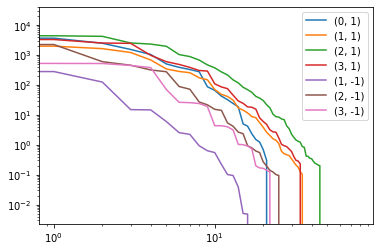

In [110]:
for i in range(len(rho2i_eva_blocks)):
    plt.loglog(rho2i_eva_blocks[i]*1e3, label = (rho2i.keys[i]["spherical_harmonics_l"],rho2i.keys[i]["inversion_sigma"] ))
#     plt.loglog(rho2i_eva_blocks[1]*1e3,'r--')
#     plt.loglog(rho2i_eva_blocks[2]*1e3,'r:')
plt.legend()

In [79]:
rho3i = cg_increment(rho2i_pca, rho1i, clebsch_gordan=cg, lcut=3, other_keys_match=["species_center"])
# rho4i = cg_increment(rho3i, rho1i, clebsch_gordan=cg, lcut=3, other_keys_match=["species_center"])
# rho5i = cg_increment(rho4i, rho1i, clebsch_gordan=cg, lcut=0, other_keys_match=["species_center"])

In [116]:
rho3i_pca, rho3i_vh_blocks, rho3i_eva_blocks = compute_rhoi_pca(rho3i, npca=[80, 180, 200, 100, 120, 120, 180,  30])

(160,) (160, 320)
singular values [1.00000000e+00 2.25403189e-01 1.74569832e-01 1.07639872e-01
 7.33378036e-02 4.25293251e-02 3.42989867e-02 3.14657784e-02
 2.55943569e-02 2.14286169e-02 2.09976510e-02 1.98998002e-02
 1.10873219e-02 9.87635037e-03 9.12981015e-03 7.01771080e-03
 6.32121103e-03 5.91260654e-03 5.42537972e-03 4.12673741e-03
 4.04370097e-03 3.20357968e-03 3.08678847e-03 2.76830711e-03
 2.63105559e-03 2.10586491e-03 1.87158840e-03 1.69293071e-03
 1.25274295e-03 1.21689497e-03 8.55628097e-04 7.86336494e-04
 7.09155383e-04 6.71545394e-04 5.84337154e-04 5.37196190e-04
 4.62567630e-04 4.49505435e-04 3.70747325e-04 3.52197952e-04
 2.90525604e-04 2.80809527e-04 2.64845764e-04 2.49762258e-04
 2.29385068e-04 2.09304502e-04 2.07576463e-04 1.74716092e-04
 1.55268199e-04 1.38807482e-04 1.12537182e-04 1.08482438e-04
 8.65702332e-05 7.07835828e-05 6.94052637e-05 6.09487757e-05
 5.91535753e-05 4.78042027e-05 4.18566275e-05 4.00163005e-05
 3.55579329e-05 3.37153880e-05 3.28527558e-05 3.095

(2000, 7, 100)
(240,) (240, 400)
singular values [1.00000000e+00 6.89882328e-01 5.72698022e-01 4.73715969e-01
 3.34850473e-01 2.97390653e-01 2.25274080e-01 1.68145374e-01
 1.40263578e-01 1.20259194e-01 1.12333048e-01 9.69017763e-02
 9.35096932e-02 8.64182047e-02 7.89921005e-02 5.78962726e-02
 5.44038949e-02 5.19110795e-02 4.76442904e-02 3.93670761e-02
 3.63311013e-02 3.47510153e-02 2.38380327e-02 2.33636635e-02
 2.20298912e-02 2.06861136e-02 1.99521410e-02 1.83684544e-02
 1.70111368e-02 1.63843275e-02 1.57879319e-02 1.54570895e-02
 1.40296794e-02 9.84539017e-03 8.92311938e-03 7.88105489e-03
 7.18741871e-03 6.33604613e-03 5.36668459e-03 5.21701829e-03
 4.89471931e-03 4.41722053e-03 4.08494050e-03 3.75558090e-03
 3.65096158e-03 3.28852445e-03 3.19192150e-03 2.82087041e-03
 2.45830134e-03 2.35934766e-03 2.25173455e-03 2.07914478e-03
 1.93958001e-03 1.82422460e-03 1.71965348e-03 1.51429136e-03
 1.31961557e-03 1.21162552e-03 1.18070233e-03 1.10589996e-03
 1.03632515e-03 9.73869694e-04 9.134

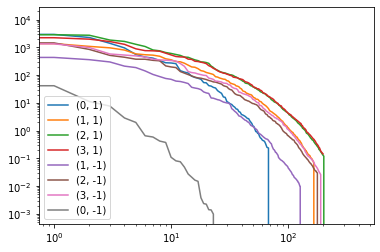

In [117]:
for i in range(len(rho3i_eva_blocks)):
    plt.loglog(rho3i_eva_blocks[i]*1e3, label = (rho3i.keys[i]["spherical_harmonics_l"],rho3i.keys[i]["inversion_sigma"] ))
#     plt.loglog(rho2i_eva_blocks[1]*1e3,'r--')
#     plt.loglog(rho2i_eva_blocks[2]*1e3,'r:')
plt.legend()

In [118]:
rho4i = cg_increment(rho3i_pca, rho1i, clebsch_gordan=cg, lcut=3, other_keys_match=["species_center"])

In [ ]:
rho4i_pca, rho4i_vh_blocks, rho4i_eva_blocks = compute_rhoi_pca(rho4i, npca=[150, 300, 500, 500, 500, 300, 300,120])

(300,) (300, 2240)
singular values [1.00000000e+00 2.52432650e-01 2.13904048e-01 1.31502025e-01
 8.97756311e-02 5.82127251e-02 4.62641421e-02 4.20839442e-02
 3.42072324e-02 2.97060036e-02 2.83147987e-02 2.63908872e-02
 2.00373921e-02 1.61474359e-02 1.51388526e-02 1.34168715e-02
 1.16254152e-02 1.05109409e-02 9.77432999e-03 9.17260188e-03
 8.97553938e-03 8.05073727e-03 7.66850688e-03 7.60297884e-03
 7.22385921e-03 6.48840143e-03 6.29325181e-03 5.99470501e-03
 5.68559914e-03 5.48318354e-03 5.17111818e-03 5.00025348e-03
 4.86638725e-03 4.78674637e-03 4.55777944e-03 4.26497260e-03
 3.76621437e-03 3.64012900e-03 3.38899756e-03 3.34314674e-03
 3.13972552e-03 3.01221955e-03 2.83199759e-03 2.60276229e-03
 2.48262699e-03 2.28245676e-03 2.24947189e-03 2.05564107e-03
 1.99929699e-03 1.87164209e-03 1.82619862e-03 1.73195319e-03
 1.60744427e-03 1.53702778e-03 1.47398461e-03 1.45976381e-03
 1.41466226e-03 1.30354395e-03 1.27796911e-03 1.24353549e-03
 1.14549519e-03 1.10842753e-03 1.04320812e-03 1.00

(2000, 5, 500)
(1000,) (1000, 3520)
singular values [1.00000000e+00 2.62800386e-01 2.40381548e-01 1.90612985e-01
 1.68044374e-01 1.07761241e-01 9.26144765e-02 8.89426056e-02
 8.15693741e-02 7.62781953e-02 6.37411734e-02 6.09505330e-02
 5.58639663e-02 5.02698037e-02 4.93685017e-02 4.86048741e-02
 4.38927599e-02 4.35274816e-02 4.17110475e-02 3.92472560e-02
 3.54629446e-02 3.40973628e-02 3.21338861e-02 3.04639880e-02
 3.01360796e-02 2.84970968e-02 2.72048759e-02 2.65051618e-02
 2.61510886e-02 2.46018530e-02 2.43535274e-02 2.28809619e-02
 2.11779839e-02 2.07068007e-02 2.04260634e-02 1.96212369e-02
 1.89085210e-02 1.84933129e-02 1.83245426e-02 1.79832325e-02
 1.76972222e-02 1.71152216e-02 1.68608210e-02 1.65849509e-02
 1.61943042e-02 1.57392924e-02 1.50546871e-02 1.47456707e-02
 1.42023042e-02 1.38343172e-02 1.32681538e-02 1.30666871e-02
 1.21131356e-02 1.18526589e-02 1.17760702e-02 1.15471960e-02
 1.13596076e-02 1.13057641e-02 1.10501526e-02 1.08068743e-02
 1.03429710e-02 1.00680687e-02 9.

(2000, 3, 500)
(600,) (600, 3800)
singular values [1.00000000e+00 7.33221503e-01 4.02722596e-01 2.67916249e-01
 2.39974837e-01 1.95485980e-01 1.88336614e-01 1.83332897e-01
 1.73526812e-01 1.50141612e-01 1.43463437e-01 1.23377348e-01
 1.11589461e-01 1.09134474e-01 1.03420745e-01 1.00493729e-01
 9.57142080e-02 9.45879809e-02 8.96824155e-02 8.47715106e-02
 8.05767056e-02 7.95423039e-02 7.40649179e-02 7.04532329e-02
 6.60351369e-02 6.26658404e-02 6.12800650e-02 6.02314730e-02
 5.97727651e-02 5.54531407e-02 5.27862929e-02 4.96015694e-02
 4.81145522e-02 4.74024017e-02 4.63034761e-02 4.42321916e-02
 4.32564162e-02 4.30060836e-02 4.21255412e-02 4.13308483e-02
 3.93453616e-02 3.84296650e-02 3.62914991e-02 3.41580158e-02
 3.35179199e-02 3.29472864e-02 3.16018000e-02 3.08665284e-02
 3.03878995e-02 2.96120110e-02 2.91558669e-02 2.87019219e-02
 2.76395469e-02 2.73263044e-02 2.57122097e-02 2.52156795e-02
 2.38403285e-02 2.37538685e-02 2.26222006e-02 2.20688225e-02
 2.16874509e-02 2.12712597e-02 2.07

In [ ]:
for i in range(len(rho4i_eva_blocks)):
    plt.loglog(rho4i_eva_blocks[i]*1e3, label = (rho4i.keys[i]["spherical_harmonics_l"],rho4i.keys[i]["inversion_sigma"] ))
#     plt.loglog(rho2i_eva_blocks[1]*1e3,'r--')
#     plt.loglog(rho2i_eva_blocks[2]*1e3,'r:')
plt.legend()

In [51]:
rho5i = cg_increment(rho4i_pca, rho1i, clebsch_gordan=cg, lcut=3, other_keys_match=["species_center"])

TensorBlock
    samples (2000): ['structure', 'center']
    components (1): ['spherical_harmonics_m']
    properties (1): ['pca']
    gradients: no

In [ ]:
rho5i_pca, rho5i_vh_blocks, rho5i_eva_blocks = compute_rhoi_pca(rho5i, npca=[150, 300, 300, 300, 200, 300, 300,120])

In [ ]:
for i in range(len(rho5i_eva_blocks)):
    plt.loglog(rho5i_eva_blocks[i]*1e3, label = (rho5i.keys[i]["spherical_harmonics_l"],rho5i.keys[i]["inversion_sigma"] ))

plt.legend()

In [ ]:
rho6i = cg_increment(rho5i_pca, rho1i, clebsch_gordan=cg, lcut=3, other_keys_match=["species_center"])

In [ ]:
rho6i_pca, rho6i_vh_blocks, rho6i_eva_blocks = compute_rhoi_pca(rho6i, npca=[150, 300, 300, 300, 200, 300, 300,120])

In [ ]:
for i in range(len(rho6i_eva_blocks)):
    plt.loglog(rho6i_eva_blocks[i]*1e3, label = (rho6i.keys[i]["spherical_harmonics_l"],rho6i.keys[i]["inversion_sigma"] ))

plt.legend()

In [ ]:
rho7i = cg_increment(rho6i_pca, rho1i, clebsch_gordan=cg, lcut=0, other_keys_match=["species_center"])

## encoder-decoder like architecture - nope

In [20]:
import equistore
import torch
import equistore.operations as operations
from tqdm import tqdm
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  


class featDataset(torch.utils.data.Dataset):
    #Dataset class
    def __init__(self, feature_path, frames):
        #
        self.features = np.load(feature_path, mmap_mode = 'r')
        self.keys_features = equistore.io._labels_from_npz(self.features["keys"])
        self.currentkey = 0
        self.frames = frames

    def __len__(self):
        return len(self.frames)
    
    def __getitem__(self, structure_idx):
        feature_block, feature_key = self.generate_feature_block(self.features, structure_idx)        
        #samples_filter, target_block_samples = self.get_index_from_idx(self.target.block(self.currentkey).samples, structure_idx)
        structure = [frames[i] for i in structure_idx]
        #Modify feature_block to tensormap
        feature_map = TensorMap(feature_key, feature_block)
        return feature_map, structure

    
    def generate_feature_block(self, memmap, structure_idx):
        #Generate the block from npz file
        output = []
        if self.currentkey is None:
            feature_key = self.keys_features     
        else:
            feature_key = Labels(["order_nu", "inversion_sigma", "spherical_harmonics_l", "species_center", "species_neighbor_a", "species_neighbor_b"], 
                                 np.asarray(self.keys_features[self.currentkey].astype(list), dtype=np.int32).reshape(-1,6))

#             feature_key = [self.keys_features[self.currentkey]]
        for key in feature_key:
            block_index = list(self.keys_features).index(key)
            prefix = f"blocks/{block_index}/values"        
            block_samples = equistore.io._labels_from_npz(memmap[f"{prefix}/samples"])
            block_components = []
            for i in range(1):
                block_components.append(equistore.io._labels_from_npz(memmap[f"{prefix}/components/{i}"]))
            block_properties = equistore.io._labels_from_npz(memmap[f"{prefix}/properties"])
             

            samples_filter, block_samples = self.get_index_from_idx(block_samples, structure_idx)

            block_data = memmap[f"{prefix}/data"][samples_filter]
            block = TensorBlock(block_data, block_samples, block_components, block_properties)
            output.append(block)
        return output, feature_key
    
    def get_n_properties(self, memmap, key):
        block_index = list(self.keys_features).index(key)
        prefix = f"blocks/{block_index}/values"  
        block_properties = equistore.io._labels_from_npz(memmap[f"{prefix}/properties"])
        
        return len(block_properties)
    
    def get_index_from_idx(self, block_samples, structure_idx):
        #Get samples label from IDX
        samples = Labels(names = ['structure'], values = np.array(structure_idx).reshape(-1,1))
        all_samples = block_samples[['structure']].tolist()
        set_samples_to_slice = set(samples.tolist())
        samples_filter = np.array(
            [sample in set_samples_to_slice for sample in all_samples]
        )
        new_samples = block_samples[samples_filter]
        
        return samples_filter, new_samples
    
    def collate_output_values(blocks):
        feature_out = []
        for sample_output in blocks:
            feature_block, structure = sample_output
            for z in feature_block:
                feature_out.append(torch.tensor(z.values))

        return feature_out


In [21]:
def mse_loss(pred, target):
    return torch.mean((pred - target)**2)


class BlockEncoderDecoder(torch.nn.Module):
    def __init__(self, seed=123, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = torch.nn.Linear(
            in_features=kwargs["input_size"], out_features=kwargs["hidden_size"]
        )
        self.encoder_output_layer = torch.nn.Linear(
            in_features=kwargs["hidden_size"], out_features=kwargs["intermediate_size"]
        )
        self.decoder_hidden_layer = torch.nn.Linear(
            in_features=kwargs["intermediate_size"], out_features=kwargs["hidden_size"]
        )
        self.decoder_output_layer = torch.nn.Linear(
            in_features=kwargs["hidden_size"], out_features=kwargs["input_size"]
        )
        self.to(device)
        
    def forward(self, x):
        print("from block forward", x.keys)
        x = torch.from_numpy(x.block().values)
        activation = self.encoder_hidden_layer(x)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

    
    def fit(self,traindata_loader, loss_function, optimizer_type, lr, reg, n_epochs):
        if optimizer_type == "Adam":
            optimizer = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = reg.item())
            threshold = 200
            scheduler_threshold = 50
            tol = 0
            history_step = 1000
        
        elif optimizer_type == "LBFGS":
            optimizer = torch.optim.LBFGS(self.parameters(), lr = lr)
            threshold = 30
            scheduler_threshold = 10
            tol = 0
            history_step = 10
            
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, scheduler_threshold, gamma = 0.5)
        best_state = copy.deepcopy(self.state_dict())
        lowest_loss = torch.tensor(9999)
        pred_loss = torch.tensor(0)
        trigger = 0
        loss_history = []
        pbar = tqdm(range(n_epochs))
        
        for epoch in pbar:
            pbar.set_description(f"Epoch: {epoch}")
            pbar.set_postfix(pred_loss = pred_loss.item(), lowest_loss = lowest_loss.item(), trigger = trigger)
            
            for x_data, structure in traindata_loader: 
                optimizer.zero_grad()
                #x_data, y_data = x_data.to(self.device), y_data.to(self.device)
                if optimizer_type == "LBFGS":
                    def closure():
                        optimizer.zero_grad()
                        _pred = self.forward(x_data)                                        
                        _pred_loss = loss_function(_pred, x_data.block().values)
                        _pred_loss = torch.nan_to_num(_pred_loss, nan=lowest_loss.item(), posinf = lowest_loss.item(), neginf = lowest_loss.item())                 
                        _reg_loss = self.get_regression_values(reg.item()) #Only works for 1 layer
                        _new_loss = _pred_loss + _reg_loss
                        _new_loss.backward()
                        return _new_loss
                    optimizer.step(closure)

                elif optimizer_type == "Adam":
                    pred = self.forward(x_data)
#                     print(pred, x_data.block().values )
                    pred_loss = loss_function(pred, torch.from_numpy(x_data.block().values))
                    
                    #reg_loss = self.get_regression_values(reg.item())#Only works for 1 layer
                    new_loss = pred_loss #+ reg_loss
                    new_loss.backward()

                    optimizer.step()
                
            with torch.no_grad():
                current_loss = 0 
                for x_data, structure in traindata_loader:
                    pred = self.forward(x_data)
                    current_loss  += loss_function(pred, torch.from_numpy(x_data.block().values)) #Loss should be normalized already
                pred_loss = current_loss
                reg_loss = self.get_regression_values(reg.item()) 
                new_loss = pred_loss + reg_loss
                if pred_loss >100000 or (pred_loss.isnan().any()) :
                    print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
                    self.load_state_dict(best_state)
                    if optimizer_type == "Adam":
                        optimizer = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = reg.item())
                    elif optimizer_type == "LBFGS":
                        optimizer = torch.optim.LBFGS(self.parameters(), lr = lr)

                if epoch % history_step == 1:
                    loss_history.append(lowest_loss.item())
                
                if lowest_loss - new_loss > tol: #threshold to stop training
                    best_state = copy.deepcopy(self.state_dict())
                    lowest_loss = new_loss 
                    trigger = 0    
                    
                else:
                    trigger += 1
                    scheduler.step()
                    if trigger > threshold:
                        self.load_state_dict(best_state)
                        print ("Implemented early stopping with lowest_loss: {}".format(lowest_loss))
                        return loss_history
        return loss_history
    
    def get_regression_values(self, reg_weights):
        output = []
        for param in self.parameters():
            output.append(torch.sum(torch.pow(param,2)))
        try:
            output = torch.sum(torch.tensor(output) * reg_weights)
        except:
            output = 0
        return output


    

class ThreeCenterModel(torch.nn.ModuleDict):
    
    def __init__(self, feature, hidden_size=128, intermediate_size=18):
        super().__init__()
        self.feature = feature
        self.loss_history={}
        self.models = torch.nn.ModuleDict()
        for k, b in self.feature:
            input_size = b.values.shape[-1]
#             print(k,input_size, hidden_size, intermediate_size)
            self.models[str(k)] = BlockEncoderDecoder(input_size=input_size, hidden_size=hidden_size, intermediate_size=intermediate_size)            
        self.to(device)
    
    def forward(self, feature):
        pred_blocks =[]
        for k, block in feature:
#             print(self[str(k)])
            
            recons = self.models[str(k)].forward(block) # expects a tensorMap
            
            newblock = TensorBlock(
                        values=recons.reshape(block.values.shape),
                        samples=block.samples,
                        components=block.components,
                        properties= block.properties
                    )
            pred_blocks.append(newblock) 
        
        keys = feature.keys
        pred_target = TensorMap(keys, pred_blocks)
        return(pred_target)
    
    def fit(self, train_dataloader, regularization_dict, optimizer_type, n_epochs, loss_function, lr):
        #Iterates through the keys of self.model, then for each key we will fit self.model[key] with data[key]
        total = len(self.models)
        for index, key in enumerate(self.feature.keys):
            print ("Now training on Block {} of {}".format(index, total))
            train_dataloader.dataset.currentkey = index
            
            loss_history_key = self.models[str(key)].fit(train_dataloader, loss_function, optimizer_type, lr, regularization_dict[str(key)], n_epochs)

            self.loss_history[str(key)] = loss_history_key

    
    


In [22]:
regularization_dict={}
for key in rhoii1i2_nu1.keys:
    regularization_dict[str(key)] = torch.tensor(0)

In [23]:
def collate_blocks(block_tuple):
    feature_tensor_map, structure_array = block_tuple[0]
    return feature_tensor_map, structure_array

train_feature_path ="./rhoii1i2n1_400.npz"
train = featDataset(train_feature_path, frames[:400])
train_Sampler = torch.utils.data.sampler.SequentialSampler(train)
train_BSampler = torch.utils.data.sampler.BatchSampler(train_Sampler, batch_size = 500, drop_last = False)

test_feature_path ="./rhoii1i2n1_400-500.npz"
test = featDataset(train_feature_path, frames[400:500])
test_Sampler = torch.utils.data.sampler.SequentialSampler(test)
test_BSampler = torch.utils.data.sampler.BatchSampler(test_Sampler, batch_size = 500, drop_last = False)

train_loader = torch.utils.data.DataLoader(train, sampler = train_BSampler, collate_fn = collate_blocks)
test_loader = torch.utils.data.DataLoader(test, sampler = test_BSampler, collate_fn = collate_blocks)

In [24]:
# rhoii1i2_nu1.keys[
rhoii1i2_nu1.blocks_matching(species_center=3)
# ]

[9, 10, 11, 12, 13, 14, 15, 16, 17]

In [25]:
model = ThreeCenterModel(rhoii1i2_nu1)

In [26]:
model.fit(train_loader, regularization_dict, optimizer_type="Adam", n_epochs=2, loss_function=mse_loss, lr=0.01)

Now training on Block 0 of 27


Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 1, 1, 1)]
from block forward [(3, 1, 0, 1, 1, 1)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.94it/s, lowest_loss=0.000316, pred_loss=0.000316, trigger=0]


from block forward [(3, 1, 0, 1, 1, 1)]
from block forward [(3, 1, 0, 1, 1, 1)]
Now training on Block 1 of 27


Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 1, 1, 3)]


Epoch: 1:   0%|                                                                                   | 0/2 [00:00<?, ?it/s, lowest_loss=0.000289, pred_loss=0.000289, trigger=0]

from block forward [(3, 1, 0, 1, 1, 3)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.65it/s, lowest_loss=0.000289, pred_loss=0.000289, trigger=0]


from block forward [(3, 1, 0, 1, 1, 3)]
from block forward [(3, 1, 0, 1, 1, 3)]
Now training on Block 2 of 27


Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 1, 1, 12)]


Epoch: 1:  50%|█████████████████████████████████████▌                                     | 1/2 [00:00<00:00,  2.98it/s, lowest_loss=0.000274, pred_loss=0.000274, trigger=0]

from block forward [(3, 1, 0, 1, 1, 12)]
from block forward [(3, 1, 0, 1, 1, 12)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.59it/s, lowest_loss=0.000274, pred_loss=0.000274, trigger=0]


from block forward [(3, 1, 0, 1, 1, 12)]
Now training on Block 3 of 27


Epoch: 1:   0%|                                                                                     | 0/2 [00:00<?, ?it/s, lowest_loss=0.00033, pred_loss=0.00033, trigger=0]

from block forward [(3, 1, 0, 1, 3, 1)]
from block forward [(3, 1, 0, 1, 3, 1)]
from block forward [(3, 1, 0, 1, 3, 1)]


Epoch: 1: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.25it/s, lowest_loss=0.00033, pred_loss=0.00033, trigger=0]


from block forward [(3, 1, 0, 1, 3, 1)]
Now training on Block 4 of 27


Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 1, 3, 3)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.19it/s, lowest_loss=0.000274, pred_loss=0.000274, trigger=0]


from block forward [(3, 1, 0, 1, 3, 3)]
from block forward [(3, 1, 0, 1, 3, 3)]
from block forward [(3, 1, 0, 1, 3, 3)]
Now training on Block 5 of 27


Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 1, 3, 12)]


Epoch: 1:  50%|█████████████████████████████████████▌                                     | 1/2 [00:00<00:00,  4.48it/s, lowest_loss=0.000313, pred_loss=0.000313, trigger=0]

from block forward [(3, 1, 0, 1, 3, 12)]
from block forward [(3, 1, 0, 1, 3, 12)]
from block forward [(3, 1, 0, 1, 3, 12)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.75it/s, lowest_loss=0.000313, pred_loss=0.000313, trigger=0]


Now training on Block 6 of 27


Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 1, 12, 1)]


Epoch: 1:  50%|█████████████████████████████████████▌                                     | 1/2 [00:00<00:00,  3.03it/s, lowest_loss=0.000278, pred_loss=0.000278, trigger=0]

from block forward [(3, 1, 0, 1, 12, 1)]
from block forward [(3, 1, 0, 1, 12, 1)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.13it/s, lowest_loss=0.000278, pred_loss=0.000278, trigger=0]


from block forward [(3, 1, 0, 1, 12, 1)]
Now training on Block 7 of 27


Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 1, 12, 3)]


Epoch: 1:  50%|█████████████████████████████████████▌                                     | 1/2 [00:00<00:00,  4.61it/s, lowest_loss=0.000262, pred_loss=0.000262, trigger=0]

from block forward [(3, 1, 0, 1, 12, 3)]
from block forward [(3, 1, 0, 1, 12, 3)]
from block forward [(3, 1, 0, 1, 12, 3)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.97it/s, lowest_loss=0.000262, pred_loss=0.000262, trigger=0]


Now training on Block 8 of 27


Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 1, 12, 12)]
from block forward [(3, 1, 0, 1, 12, 12)]


Epoch: 1:  50%|█████████████████████████████████████▌                                     | 1/2 [00:01<00:01,  1.61s/it, lowest_loss=0.000236, pred_loss=0.000236, trigger=0]

from block forward [(3, 1, 0, 1, 12, 12)]
from block forward [(3, 1, 0, 1, 12, 12)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it, lowest_loss=0.000236, pred_loss=0.000236, trigger=0]


Now training on Block 9 of 27


Epoch: 1:  50%|█████████████████████████████████████▌                                     | 1/2 [00:00<00:00,  9.27it/s, lowest_loss=0.000246, pred_loss=0.000246, trigger=0]

from block forward [(3, 1, 0, 3, 1, 1)]
from block forward [(3, 1, 0, 3, 1, 1)]
from block forward [(3, 1, 0, 3, 1, 1)]
from block forward [(3, 1, 0, 3, 1, 1)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.99it/s, lowest_loss=0.000246, pred_loss=0.000246, trigger=0]


Now training on Block 10 of 27


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.86it/s, lowest_loss=0.000291, pred_loss=0.000291, trigger=0]


from block forward [(3, 1, 0, 3, 1, 3)]
from block forward [(3, 1, 0, 3, 1, 3)]
from block forward [(3, 1, 0, 3, 1, 3)]
from block forward [(3, 1, 0, 3, 1, 3)]
Now training on Block 11 of 27


Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 3, 1, 12)]


Epoch: 1:  50%|█████████████████████████████████████▌                                     | 1/2 [00:00<00:00,  2.64it/s, lowest_loss=0.000322, pred_loss=0.000322, trigger=0]

from block forward [(3, 1, 0, 3, 1, 12)]
from block forward [(3, 1, 0, 3, 1, 12)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s, lowest_loss=0.000322, pred_loss=0.000322, trigger=0]


from block forward [(3, 1, 0, 3, 1, 12)]
Now training on Block 12 of 27


Epoch: 1:  50%|█████████████████████████████████████▌                                     | 1/2 [00:00<00:00,  9.94it/s, lowest_loss=0.000278, pred_loss=0.000278, trigger=0]

from block forward [(3, 1, 0, 3, 3, 1)]
from block forward [(3, 1, 0, 3, 3, 1)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.21it/s, lowest_loss=0.000278, pred_loss=0.000278, trigger=0]


from block forward [(3, 1, 0, 3, 3, 1)]
from block forward [(3, 1, 0, 3, 3, 1)]
Now training on Block 13 of 27


Epoch: 1:  50%|█████████████████████████████████████▌                                     | 1/2 [00:00<00:00,  7.94it/s, lowest_loss=0.000309, pred_loss=0.000309, trigger=0]

from block forward [(3, 1, 0, 3, 3, 3)]
from block forward [(3, 1, 0, 3, 3, 3)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.78it/s, lowest_loss=0.000309, pred_loss=0.000309, trigger=0]

from block forward [(3, 1, 0, 3, 3, 3)]
from block forward [(3, 1, 0, 3, 3, 3)]
Now training on Block 14 of 27



Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 3, 3, 12)]


Epoch: 1:  50%|█████████████████████████████████████▌                                     | 1/2 [00:00<00:00,  1.80it/s, lowest_loss=0.000303, pred_loss=0.000303, trigger=0]

from block forward [(3, 1, 0, 3, 3, 12)]
from block forward [(3, 1, 0, 3, 3, 12)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.92it/s, lowest_loss=0.000303, pred_loss=0.000303, trigger=0]


from block forward [(3, 1, 0, 3, 3, 12)]
Now training on Block 15 of 27


Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 3, 12, 1)]


Epoch: 1:  50%|█████████████████████████████████████▌                                     | 1/2 [00:00<00:00,  2.97it/s, lowest_loss=0.000336, pred_loss=0.000336, trigger=0]

from block forward [(3, 1, 0, 3, 12, 1)]
from block forward [(3, 1, 0, 3, 12, 1)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s, lowest_loss=0.000336, pred_loss=0.000336, trigger=0]


from block forward [(3, 1, 0, 3, 12, 1)]
Now training on Block 16 of 27


Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 3, 12, 3)]


Epoch: 1:  50%|█████████████████████████████████████▌                                     | 1/2 [00:00<00:00,  1.65it/s, lowest_loss=0.000288, pred_loss=0.000288, trigger=0]

from block forward [(3, 1, 0, 3, 12, 3)]
from block forward [(3, 1, 0, 3, 12, 3)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.78it/s, lowest_loss=0.000288, pred_loss=0.000288, trigger=0]


from block forward [(3, 1, 0, 3, 12, 3)]
Now training on Block 17 of 27


Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 3, 12, 12)]
from block forward [(3, 1, 0, 3, 12, 12)]


Epoch: 1:  50%|██████████████████████████████████████▌                                      | 1/2 [00:10<00:10, 10.12s/it, lowest_loss=0.00034, pred_loss=0.00034, trigger=0]

from block forward [(3, 1, 0, 3, 12, 12)]
from block forward [(3, 1, 0, 3, 12, 12)]


Epoch: 1: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:17<00:00,  8.57s/it, lowest_loss=0.00034, pred_loss=0.00034, trigger=0]


Now training on Block 18 of 27


Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 12, 1, 1)]
from block forward [(3, 1, 0, 12, 1, 1)]


Epoch: 1:  50%|█████████████████████████████████████▌                                     | 1/2 [00:00<00:00,  3.13it/s, lowest_loss=0.000322, pred_loss=0.000322, trigger=0]

from block forward [(3, 1, 0, 12, 1, 1)]
from block forward [(3, 1, 0, 12, 1, 1)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.39it/s, lowest_loss=0.000322, pred_loss=0.000322, trigger=0]


Now training on Block 19 of 27


Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 12, 1, 3)]
from block forward [(3, 1, 0, 12, 1, 3)]


Epoch: 1:  50%|█████████████████████████████████████▌                                     | 1/2 [00:00<00:00,  4.04it/s, lowest_loss=0.000277, pred_loss=0.000277, trigger=0]

from block forward [(3, 1, 0, 12, 1, 3)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.00it/s, lowest_loss=0.000277, pred_loss=0.000277, trigger=0]

from block forward [(3, 1, 0, 12, 1, 3)]
Now training on Block 20 of 27



Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 12, 1, 12)]


Epoch: 1:  50%|█████████████████████████████████████▌                                     | 1/2 [00:00<00:00,  1.03it/s, lowest_loss=0.000318, pred_loss=0.000318, trigger=0]

from block forward [(3, 1, 0, 12, 1, 12)]
from block forward [(3, 1, 0, 12, 1, 12)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.09it/s, lowest_loss=0.000318, pred_loss=0.000318, trigger=0]

from block forward [(3, 1, 0, 12, 1, 12)]
Now training on Block 21 of 27



Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 12, 3, 1)]
from block forward [(3, 1, 0, 12, 3, 1)]


Epoch: 1:  50%|██████████████████████████████████████▌                                      | 1/2 [00:00<00:00,  2.41it/s, lowest_loss=0.00029, pred_loss=0.00029, trigger=0]

from block forward [(3, 1, 0, 12, 3, 1)]


Epoch: 1: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.66it/s, lowest_loss=0.00029, pred_loss=0.00029, trigger=0]


from block forward [(3, 1, 0, 12, 3, 1)]
Now training on Block 22 of 27


Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 12, 3, 3)]
from block forward [(3, 1, 0, 12, 3, 3)]


Epoch: 1:  50%|██████████████████████████████████████▌                                      | 1/2 [00:00<00:00,  1.24it/s, lowest_loss=0.00037, pred_loss=0.00037, trigger=0]

from block forward [(3, 1, 0, 12, 3, 3)]


Epoch: 1: 100%|█████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.19it/s, lowest_loss=0.00037, pred_loss=0.00037, trigger=0]


from block forward [(3, 1, 0, 12, 3, 3)]
Now training on Block 23 of 27


Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 12, 3, 12)]
from block forward [(3, 1, 0, 12, 3, 12)]


Epoch: 1:  50%|█████████████████████████████████████▌                                     | 1/2 [00:03<00:03,  3.08s/it, lowest_loss=0.000274, pred_loss=0.000274, trigger=0]

from block forward [(3, 1, 0, 12, 3, 12)]
from block forward [(3, 1, 0, 12, 3, 12)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.30s/it, lowest_loss=0.000274, pred_loss=0.000274, trigger=0]


Now training on Block 24 of 27


Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 12, 12, 1)]
from block forward [(3, 1, 0, 12, 12, 1)]


Epoch: 1:  50%|█████████████████████████████████████▌                                     | 1/2 [00:01<00:01,  1.08s/it, lowest_loss=0.000341, pred_loss=0.000341, trigger=0]

from block forward [(3, 1, 0, 12, 12, 1)]
from block forward [(3, 1, 0, 12, 12, 1)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.17s/it, lowest_loss=0.000341, pred_loss=0.000341, trigger=0]


Now training on Block 25 of 27


Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 12, 12, 3)]
from block forward [(3, 1, 0, 12, 12, 3)]


Epoch: 1:  50%|█████████████████████████████████████▌                                     | 1/2 [00:04<00:04,  4.51s/it, lowest_loss=0.000298, pred_loss=0.000298, trigger=0]

from block forward [(3, 1, 0, 12, 12, 3)]
from block forward [(3, 1, 0, 12, 12, 3)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.85s/it, lowest_loss=0.000298, pred_loss=0.000298, trigger=0]


Now training on Block 26 of 27


Epoch: 0:   0%|                                                                                              | 0/2 [00:00<?, ?it/s, lowest_loss=9999, pred_loss=0, trigger=0]

from block forward [(3, 1, 0, 12, 12, 12)]
from block forward [(3, 1, 0, 12, 12, 12)]


Epoch: 1:  50%|█████████████████████████████████████▌                                     | 1/2 [00:19<00:19, 19.76s/it, lowest_loss=0.000311, pred_loss=0.000311, trigger=0]

from block forward [(3, 1, 0, 12, 12, 12)]
from block forward [(3, 1, 0, 12, 12, 12)]


Epoch: 1: 100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:39<00:00, 19.59s/it, lowest_loss=0.000311, pred_loss=0.000311, trigger=0]


In [28]:
for x_data, structures in test_loader:
#     print(x_data)
    pred = model(x_data)
#     print ("Test error for mse_full is {}".format(mse_full(pred, )))

AttributeError: 'TensorBlock' object has no attribute 'keys'

In [ ]:
# aa=[]
# bb=[]
# for x, y in train_loader:
#     aa.append(x)
#     bb.append(y)
# from itertools import chain
# list(chain.from_iterable(bb))==frames[:400]

In [10]:
rascal_hypers = {
    "interaction_cutoff": 4.5,
    "cutoff_smooth_width": 0.3,
    "max_radial": 4,
    "max_angular": 2,
    "gaussian_sigma_type": "Constant",
    "compute_gradients":  False,
#     "expansion_by_species_method": "user defined",
#     "global_species": [1,6,8,7]
    
}

cg = ClebschGordanReal(5)

spex = RascalSphericalExpansion(rascal_hypers)
rhoi = spex.compute(frames)
pairs = RascalPairExpansion(rascal_hypers)
gij = pairs.compute(frames)

### $\rho_{i}^{\otimes 3}$

In [23]:
rho1i = acdc_standardize_keys(rhoi)
rho1i = rho1i.keys_to_properties(['species_neighbor'])

rho2i = cg_increment(rho1i, rho1i, lcut=4, other_keys_match=["species_center"], clebsch_gordan=cg)
rho3i =  cg_increment(rho2i, rho1i, lcut=0, other_keys_match=["species_center"], clebsch_gordan=cg)

### $\rho_{i i_1 i_2}^{\otimes 1}$

In [26]:
gij =  acdc_standardize_keys(gij)
rhoii1i2_nu0 = cg_combine(gij, gij, clebsch_gordan=cg,lcut=4, other_keys_match=['species_center'])
rhoii1i2_nu1 =  cg_combine(rho1i, rhoii1i2_nu0, clebsch_gordan=cg, lcut=0, other_keys_match = ['species_center'])


### check degeneracy of $\rho_{i}^{\otimes 3}$

In [30]:
np.linalg.norm(rho3i.block(species_center = 3, inversion_sigma = 1).values[0] - rho3i.block(species_center = 3, inversion_sigma = 1).values[1])

1.680772513045776e-22

In [29]:
# rhoii1i2_nu1.keys_to_properties('species_neighbor_1')
# rhoii1i2_nu1.keys_to_properties('species_neighbor_2')

In [49]:
rhoii1i2_nu1.block(species_center = 3,species_neighbor_a=12, species_neighbor_b=12, inversion_sigma=1).samples[36:72]#values.shape


Labels([(1, 0, 1, 1), (1, 0, 1, 2), (1, 0, 1, 3), (1, 0, 1, 4),
        (1, 0, 1, 5), (1, 0, 1, 6), (1, 0, 2, 1), (1, 0, 2, 2),
        (1, 0, 2, 3), (1, 0, 2, 4), (1, 0, 2, 5), (1, 0, 2, 6),
        (1, 0, 3, 1), (1, 0, 3, 2), (1, 0, 3, 3), (1, 0, 3, 4),
        (1, 0, 3, 5), (1, 0, 3, 6), (1, 0, 4, 1), (1, 0, 4, 2),
        (1, 0, 4, 3), (1, 0, 4, 4), (1, 0, 4, 5), (1, 0, 4, 6),
        (1, 0, 5, 1), (1, 0, 5, 2), (1, 0, 5, 3), (1, 0, 5, 4),
        (1, 0, 5, 5), (1, 0, 5, 6), (1, 0, 6, 1), (1, 0, 6, 2),
        (1, 0, 6, 3), (1, 0, 6, 4), (1, 0, 6, 5), (1, 0, 6, 6)],
       dtype=[('structure', '<i4'), ('center', '<i4'), ('neighbor_1', '<i4'), ('neighbor_2', '<i4')])

In [46]:
np.linalg.norm(rhoii1i2_nu1.block(species_center = 3,species_neighbor_a=1, species_neighbor_b=12, inversion_sigma=1 ).values[:36])

2.5486800904721503e-07